In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats
import datetime as dt
import os

In [2]:
calib_year = 2015
bog_elev = 422.06
lagg_elev = 421.64
upland_elev = 425.9

In [3]:
'''Correlation'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rvalue(obs, mod):
    nanmask = np.isfinite(obs)
    y = obs[nanmask]
    x = mod[nanmask]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

def calcLCE(obs, mod):
    r = rvalue(obs, mod)
    alpha = np.nanstd(mod)/np.nanstd(obs)
    beta = np.nanmean(mod)/np.nanmean(obs)
    return 1 -np.sqrt(((r*alpha - 1)**2) + ((r/alpha - 1)**2) + (beta - 1)**2)

def calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET):
    wteLCE = calcLCE(observedWTE, modelWTE)
    qLCE = calcLCE(observedQ, modelQ)
    etLCE = calcLCE(observedET, modelET)
    return np.mean([wteLCE, qLCE, etLCE])

In [4]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

dt1['WTD'] =  -(bog_elev - dt1.WTE)

# Pull out calib year
wte_calib = dt1[dt1.DATE.dt.year == calib_year]
wte_calib = wte_calib[wte_calib.PEATLAND == 'S2'].reset_index(drop = True)

# Pull out all data
wte_all = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018)]
wte_all = wte_all[wte_all.PEATLAND == 'S2'].reset_index(drop = True)

'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

#Convert cm/day to mm/day
dt2['flow_mmday'] = 10*dt2['Flow (cm/day)']

# Pull out 2017 year
stream_calib = dt2[dt2.Date.dt.year == calib_year]
stream_calib = stream_calib[stream_calib.Watershed == 'S2'].reset_index(drop = True)

# Pull out all data time range
stream_all = dt2[(dt2.Date.dt.year > 2011) & (dt2.Date.dt.year < 2018)]
stream_all = stream_all[stream_all.Watershed == 'S2'].reset_index(drop = True)

'''Load Calibration Latent Heat Flux Data'''
dt3 = xr.load_dataset('/glade/derecho/scratch/swensosc/Ameriflux/AMF_US-MBP_set.nc').to_dataframe().reset_index()

#Replace Nan
flux = dt3.replace(-9999, np.NaN)
flux['time'] = pd.to_datetime(flux.time).dt.round('15min')
#convert LE to AET
lhv = 2.5e6 #J/kg latent heat of vaporization
sphh = 1800 # seconds per half hour
flux['OET'] = flux.LE/lhv * sphh #et in mm/halfhour
#density conversion and mm to m cancel out

#resample to daily timestep
flux_daily = flux.set_index('time').resample('D').mean().reset_index() #et in mm/day
flux_daily['OET'] = flux_daily['OET']*48 #half hours to daily
flux_daily = flux_daily[(flux_daily.time.dt.year > 2011) & (flux_daily.time.dt.year < 2018)].reset_index(drop = True)

#pull out calibration data
flux_calib = flux_daily[flux_daily.time.dt.year == calib_year]

/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Text(0, 0.5, 'ET [mm/day]')

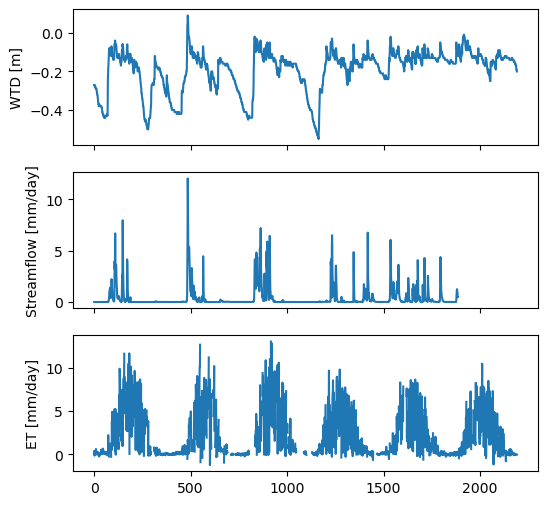

In [5]:
fig, ax = plt.subplots(3, 1, figsize = (6, 6), 
                      sharex = True)
ax[0].plot(wte_all.WTD)
ax[0].set_ylabel('WTD [m]')
ax[1].plot(stream_all.flow_mmday)
ax[1].set_ylabel('Streamflow [mm/day]')
ax[2].plot(flux_daily.OET)
ax[2].set_ylabel('ET [mm/day]')

In [6]:
medlynslope = [25, 30, 35]
wteLCE = []
qLCE = []
etLCE = []
compLCE = []

In [18]:
'''Import Hillslope Model Results'''
for slope in medlynslope:
    case_name = 'hillslope_probing_MEDLYNSLOPE_' + str(slope)
    file_dir = '/glade/derecho/scratch/marielj/archive/' + case_name + '/lnd/hist/'
    files = glob(file_dir + case_name + '.clm2.h2.*.nc')
    colfiles = glob(file_dir + case_name + '.clm2.h3.*.nc')
    save_path = '/glade/u/home/marielj/cesm-hillslope/probing-cases/figures/medlynslope_' + str(slope)
    
    data = xr.open_mfdataset(files)
    coldata = xr.open_mfdataset(colfiles)
    
    #Plot
    #Basic Time Series
    spday = 86400
    fig, ax = plt.subplots(3, 1, figsize = (6, 6), 
                          sharex = True)
    ax[0].plot(wte_all.WTD)
    ax[0].plot(-coldata.sel(column = 1).sel(time = slice("2011-01-01", "2018-01-01")).ZWT)
    ax[0].set_ylabel('WTD [m]')
    ax[1].plot(stream_all.flow_mmday)
    ax[1].plot(spday*data.sel(time = slice("2011-01-01", "2018-01-01")).QRUNOFF)
    ax[1].set_ylabel('Streamflow [mm/day]')
    ax[2].plot(flux_daily.OET)
    ax[2].plot(spday*data.sel(time = slice("2011-01-01", "2018-01-01")).QVEGT)
    ax[2].set_ylabel('ET [mm/day]')
    plt.savefig(save_path + 'timeseries.pdf')
    
    #Soil Moisture comparison
    #Convert to percent saturation
    #coldata['H2OSOI_SAT'] = coldata.H2OSOI/coldata.watsat
    #coldata['H2OSOI_SAT'] = coldata.H2OSOI_SAT.isel(levgrnd = 0, drop = True)
    fig, ax = plt.subplots(1, 3, figsize = (8, 4), 
                          sharex = True, sharey = True)
    
    coldata.sel(column = 1).sel(time = slice("2011-01-01", "2018-01-01")).H2OSOI.plot(x = 'time', yincrease = False, 
                                                                                     ax = ax[0], 
                                                                                     vmin = 0, vmax = 1,
                                                                                     add_colorbar=False)
    coldata.sel(column = 0).sel(time = slice("2011-01-01", "2018-01-01")).H2OSOI.plot(x = 'time', yincrease = False,
                                                                                     vmin = 0, vmax = 1, 
                                                                                     add_colorbar=False,
                                                                                     ax = ax[1])
    coldata.sel(column = 2).sel(time = slice("2011-01-01", "2018-01-01")).H2OSOI.plot(x = 'time', yincrease = False, 
                                                                                     vmin = 0, vmax = 1, 
                                                                                     ax = ax[2])
    ax[0].set_title('Bog')
    ax[1].set_title('Lagg')
    ax[2].set_title('Upland')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    ax[0].set_ylim(4, 0)
    plt.savefig(save_path + 'soilmoisture.pdf')
    
    #Water Budget Comparison
    data['totP'] = data.RAIN + data.SNOW
    data['ET'] = data.QVEGT + data.QSOIL
    data_annual = spday*data.groupby('time.year').sum()
    stream_all['year'] = stream_all.Date.dt.year
    flux_daily['year'] = flux_daily.time.dt.year
    #Observed
    print('--')
    print('Medlyn Slope = ' + str(slope))
    print('Observed')
    print('Precipitation: ' + str(np.mean(data_annual.totP.values)) + ' mm per year')
    print('Streamflow: ' + str(stream_all.groupby('year').sum(numeric_only = True).flow_mmday.mean()) + ' mm per year')
    print('ET: ' + str(flux_daily.groupby('year').sum(numeric_only = True).OET.mean()) + ' mm per year')
    temp = ((stream_all.groupby('year').sum(numeric_only = True).flow_mmday.mean()) + (flux_daily.groupby('year').sum(numeric_only = True).OET.mean()))/(np.mean(data_annual.totP.values))
    print('ET+Q/P = ' + str(temp))
    #Modelled
    print('--')
    print('Modelled')
    print('Streamflow: ' + str(np.mean(data_annual.QRUNOFF.values)) + ' mm per year')
    print('Transpiration: ' + str(np.mean(data_annual.QVEGT.values)) + ' mm per year')
    print('Soil Evaporation: ' + str(np.mean(data_annual.QSOIL.values)) + ' mm per year')
    print('ET: ' + str(np.mean(data_annual.ET.values)) + ' mm per year')
    temp = ((np.mean(data_annual.QRUNOFF.values))+(np.mean(data_annual.ET.values)))/(np.mean(data_annual.totP.values))
    print('ET+Q/P = ' + str(temp))
    
    #Try Lee Choi Efficiency (LCE)
    observedWTE = np.array(wte_calib.WTD)
    modelWTE = -np.array(coldata.sel(column = 1).sel(time = slice("2015-01-01", "2015-12-31")).ZWT.values)
    observedQ = np.array(stream_calib.flow_mmday)
    modelQ = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).QRUNOFF.values.ravel())
    observedET = np.array(flux_calib.OET)
    modelET = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).ET.values.ravel())
    
    print('--')
    print('Efficiency Metrics')
    print('LCE for WTE: ' + str(calcLCE(observedWTE, modelWTE)))
    print('LCE for Q: ' + str(calcLCE(observedQ, modelQ)))
    print('LCE for ET: ' + str(calcLCE(observedET, modelET)))
    print('Compound LCE: ' + str(calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET)))

    wteLCE.append(calcLCE(observedWTE, modelWTE))
    qLCE.append(calcLCE(observedQ, modelQ))
    etLCE.append(calcLCE(observedET, modelET))
    compLCE.append(calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET))

NameError: name 'medlynslope' is not defined

Text(0.5, 0, 'Grass PFT Medlyn Slope')

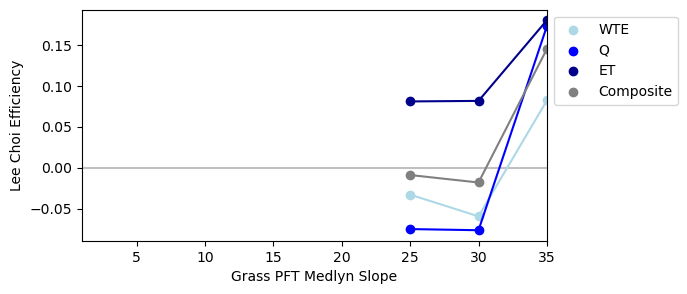

In [41]:
#Plot Lee Choi Efficiency
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

ax.hlines(0, xmin = 0, xmax = 35, color = 'silver', zorder = -1)
ax.scatter(medlynslope, wteLCE, color = 'lightblue', label = 'WTE')
ax.scatter(medlynslope, qLCE, color = 'blue', label = 'Q')
ax.scatter(medlynslope, etLCE, color = 'darkblue', label = 'ET')
ax.scatter(medlynslope, compLCE, color = 'grey', label = 'Composite')
ax.plot(medlynslope, wteLCE, color = 'lightblue')
ax.plot(medlynslope, qLCE, color = 'blue')
ax.plot(medlynslope, etLCE, color = 'darkblue')
ax.plot(medlynslope, compLCE, color = 'grey')

ax.legend(bbox_to_anchor = (1, 1))
ax.set_xlim(1, 35)
ax.set_ylabel('Lee Choi Efficiency')
ax.set_xlabel('Grass PFT Medlyn Slope')

#medlyn slope 35 case has slightly shifted pfts and also a factor of 4 on the medlyn slope for conif and decid trees

In [42]:
temp = xr.load_dataset('/glade/u/home/marielj/cesm-hillslope/calib-surf-files/clm50_params_2D_bayesopt.c240105.nc')

/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [46]:
temp.medlynslope[8]

<xarray.DataArray 'medlynslope' ()>
array(4.44999981)
Coordinates:
    pftname  |S40 b'broadleaf_deciduous_boreal_tree         '
Attributes:
    long_name:  Medlyn slope of conductance-photosynthesis relationship
    units:      umol H2O/umol CO2
    comment:    Values come from the values used in the CABLE model